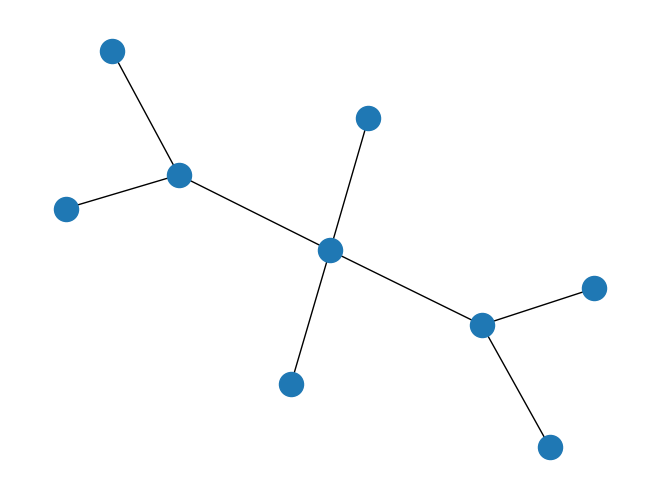

In [1]:

# conda install pytorch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0 -c pytorch -y & conda install pyg -c pyg -y & conda install -c anaconda networkx -y & conda install -c conda-forge matplotlib -y

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
import torch_geometric.utils as utils
from utils import *
from model import UpdateRule
from datasets import *



meta_set = MetaDataset()



hidden_dim = 64
# edge_dim = None
edge_dim = 8

n_inputs = meta_set.n_inputs
n_outputs = meta_set.n_outputs
height = 2
width = meta_set.n_outputs

update_rule = UpdateRule(
    n_inputs, 
    n_outputs,
    hidden_dim,
    edge_dim,
    network_width=hidden_dim,
    heads = 1
)
update_rule.build_graph(
    height,
    width,
    mode="dense"
)


# cuda_device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
cuda_device = torch.device("cpu")

update_rule = update_rule.to(cuda_device)

# edge_attr = torch.concat(
#     (
#         torch.tensor([[1,0]]*(update_rule.graph.edge_index[0].shape[0]//2)), 
#         torch.tensor([[0,1]]*(update_rule.graph.edge_index[0].shape[0]//2))
#     ), 
# 0).float()
# edge_attr = None
edge_attr = update_rule.edge_attr

update_rule.draw()



In [2]:
from training import *


optimizer = torch.optim.Adam(update_rule.parameters(), lr=0.001)

x = train_on_meta_set(
    update_rule, optimizer, meta_set, {
        "n_steps": 1,
        "batch_size" : 5,
        "n_epochs" : 10000,
    }, edge_attr = edge_attr
)

  Epoch 0 | Loss 0.254096 | Accuracy 0% | Network out: [0.332 0.338 0.33 ] | Correct:  [0. 0. 1.] | Network In: [] 
  Epoch 100 | Loss 0.249658 | Accuracy 20% | Network out: [0.091 0.286 0.623] | Correct:  [0. 0. 1.] | Network In: [] 
  Epoch 200 | Loss 0.275417 | Accuracy 20% | Network out: [9.595e-01 3.995e-02 5.504e-04] | Correct:  [0. 1. 0.] | Network In: [] 
  Epoch 300 | Loss 0.245334 | Accuracy 40% | Network out: [0.502 0.357 0.142] | Correct:  [1. 0. 0.] | Network In: [] work In: [] 
  Epoch 400 | Loss 0.241009 | Accuracy 40% | Network out: [0.002 0.402 0.596] | Correct:  [0. 0. 1.] | Network In: [] 
  Epoch 500 | Loss 0.238453 | Accuracy 60% | Network out: [0.479 0.007 0.514] | Correct:  [0. 0. 1.] | Network In: []  ork In: [] 
  Epoch 600 | Loss 0.240251 | Accuracy 20% | Network out: [0.002 0.509 0.489] | Correct:  [0. 0. 1.] | Network In: [] 
  Epoch 700 | Loss 0.237397 | Accuracy 60% | Network out: [0.488 0.51  0.002] | Correct:  [0. 1. 0.] | Network In: [] 
  Epoch 800 | L

In [ ]:
drops = [1,2,3]
class TranslateDatasett(Dataset):
    def __init__(self, diff=1, drops = None) -> None:
        n = 4
        if drops is None:
            drops = [random.randint(1, n-1)]
        # drops = [3]
        
        arr = torch.arange(n)

        for drop in drops:
            arr = torch.cat([arr[:drop-1], arr[drop:]])
        
        data = one_hot(arr, n)
        targets = one_hot((arr+diff)%n, n)
        
        
        
        
        super().__init__(data, targets)



x = update_rule.initial_state()
x, loss, network_output, correct, network_in = update_rule(
                    x, 1, DataLoader(TranslateDatasett(-1), shuffle=True), edge_attr=edge_attr
                )
print(loss, network_output, correct, network_in)

In [ ]:
for i in TranslateDatasett(1):
    print(i)

In [ ]:
import gym
import pygad
import pygad.torchga
import torch
import numpy as np

gen_start = True
def fitness_func(solution, sol_idx):
    global gen_start,keras_ga, update_rule, observation_space_size, env

    model_weights_dict = pygad.torchga.model_weights_as_dict(model=update_rule, weights_vector=solution)

    update_rule.load_state_dict(model_weights_dict)
    update_rule.reset() 
    x = update_rule.initial_state()
    
    # play game
    observation = env.reset()
    sum_reward = 0
    done = False
    c = 0
    while (not done) and c<1000:
        state = torch.tensor(np.reshape(observation, [1, observation_space_size])).float()#.to(cuda_device)
        
        x = update_rule.act(x, state, n_step=2)
        q_values = update_rule.get_output(x, softmax=False)
        # action = np.argmax(q_values.detach().cpu().numpy())
        action = q_values.detach().cpu().numpy()
        if gen_start and e % 5 == 0:
            env.render()
            
            
            
        # q_values = update_rule(state)
        # action = np.argmax(q_values[0].detach().cpu().numpy())
        observation_next, reward, done, info = env.step(action)
        observation = observation_next
        sum_reward += reward
        c += 1
    gen_start = False
    return sum_reward


e = 0
def callback_generation(ga_instance):
    global e, gen_start
    e += 1
    gen_start = True
    if not (e % 5 == 0):
        return 
    
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))


env = gym.make("BipedalWalker-v3")

observation_space_size = env.observation_space.shape[0]
# action_space_size = env.action_space.n

# print("observation_space_size =", observation_space_size)
# print("action_space_size =", action_space_size)


# update_rule = torch.nn.Sequential(
#      torch.nn.Linear(in_features=4, out_features=4),
#         torch.nn.ReLU(),
#         torch.nn.Linear(in_features=4, out_features=4),
#         torch.nn.ReLU(),
#         torch.nn.Linear(in_features=4, out_features=2),
# )

torch_ga = pygad.torchga.TorchGA(model=update_rule,
                           num_solutions=10)

ga_instance = pygad.GA(num_generations=10000,
                       num_parents_mating=5,
                       initial_population=torch_ga.population_weights,
                       fitness_func=fitness_func,
                       parent_selection_type="sss",
                       crossover_type="single_point",
                       mutation_type="random",
                       mutation_percent_genes=10,
                       keep_parents=-1,
                       random_mutation_min_val = -0.1,
                       random_mutation_max_val = 0.1,
                       on_generation=callback_generation)

ga_instance.run()


In [ ]:
from utils import *
from torch_geometric.utils import grid, remove_self_loops

def add_reverse_edges(edges):
    """
    [
        [0]
        [1]
    ]
    becomes
    [
        [0,1]
        [1,0]
    ]
    """
    edges = edges.transpose(0,1)
    return torch.stack((torch.concat((edges[0], edges[1]), 0), torch.concat((edges[1], edges[0]), 0)), 0).transpose(0,1)
    

def build_edges(n_inputs: int, n_outputs: int, height: int, width: int, mode="dense"):
    """
    Builds edges like 2d_grid_graph
    """
    #hidden neurons
    if mode == "grid":
        edge_list = list(nx.grid_2d_graph(height, width).edges())
        node_list = list(nx.grid_2d_graph(height, width).nodes())

        #replace each element of edge_list with its index in node_list
        for i in range(len(edge_list)):
            edge_list[i] = (node_list.index(edge_list[i][0]), node_list.index(edge_list[i][1]))
            
        edges = torch.tensor(edge_list)
    elif mode == "dense":
        edges = grid(height, width)[0].transpose(0,1)
    else:
        raise ValueError("mode must be either 'grid' or 'dense'")
    
    
    #input neurons
    input_edges = torch.tensor([
        [
            [x, (height*width) + y] for x in range(width)
        ] for y in range(n_inputs)
    ]).view(-1, 2)

    #output neurons
    output_edges = torch.tensor([
        [
            [(height*width)-(x+1), (height*width) + y+n_inputs] for x in range(width)
        ] for y in range(n_outputs)
    ]).view(-1, 2)

    
    input_edges = add_reverse_edges(input_edges)
    output_edges = add_reverse_edges(output_edges)
    
    # print(remove_self_loops(edges)[0].transpose(0,1))
    edges = torch.cat((edges, input_edges, output_edges), dim=0)
    edges = edges.transpose(0,1)
    edges = remove_self_loops(edges)[0]
    
    return edges

n_inputs = 3
n_outputs = 2
height = 4
width = 3
edges = build_edges(n_inputs, n_outputs, height, width)
edges

In [ ]:
from torch_geometric.data import Data
import torch
import torch_geometric.utils as utils

n_nodes = height*width# + n_inputs + n_outputs
graph = Data(edge_index=edges, x=torch.zeros(n_nodes, 2))
graph = utils.to_networkx(graph, to_undirected=True, remove_self_loops = True)
nx.draw(graph)


In [ ]:

class Dataset(torch.utils.data.Dataset):
    """
    datset superclass
    """
    def __init__(self, data, target):
        self.data = data
        self.target = target
        
    def __getitem__(self, index):
        return self.data[index], self.target[index]

    def __len__(self):
        return len(self.data)  
class TranslateDataset(Dataset):
    def __init__(self, diff=1, drops = None) -> None:
        n = 4
        if drops is None:
            drops = [random.randint(1, n-1)]
        # drops = [3]
        
        arr = torch.arange(n)
        

        for drop in drops:
            arr = torch.cat([arr[:drop-1], arr[drop:]])

        data = one_hot(arr, n)
        targets = one_hot((arr+diff)%n, n)
        
        print(data)
        data = torch.concat((data, data), 0)
        print(data)
        
        targets = torch.stack((targets, targets), 0)
        
        # data *= 2
        # targets *= 2
        
        super().__init__(data, targets)
        
TranslateDataset(0)
# for i in TranslateDataset(0):
#     print(i)

In [ ]:
n = 4
diff = 1
arr = torch.arange(n)
drops = [3]
for drop in drops:
    arr = torch.cat([arr[:drop-1], arr[drop:]])

one_hot(arr, n), one_hot((arr+diff)%n, n)

In [ ]:
a = torch.tensor([[[0.],
         [0.],
         [1.],
         [0.],
         [1.]]])

b = torch.ones_like(a)

torch.cat((a,b), dim=2)

In [ ]:
[1,2,3,4,5,6][-3:]

In [ ]:
a = torch.tensor([[1,2,3,4]])
torch.stack((a,a), 1)

In [ ]:
torch.arange(2)